## Benchmarking

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from Benchmarking import *
import sys

In [7]:
chm = 20

In [8]:
user = "arvindsk"
# user = "wknd37"

datasets_benchmark = "/home/" + user + "/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/"
metrics_benchmark = "/home/" + user + "/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/chm{0}/"
model_root = "/home/" + user + "/xgmix_expts/benchmark_data/{1}/{2}/{3}/generated_data/chm{0}/all/models/{4}_{5}.pkl"
train_data_root = "/home/" + user + "/xgmix_expts/benchmark_data/{0}/{1}/{2}/generated_data/"

train_gens = [0,2,4,8,16,24,32,48,64,72,100]
val_gens = [2,4,8,12,16,20,30,40,50,60,70,80,90,100]

In [9]:
verbose=True

In [11]:
for set_name in ["full","ukb"]:
    W = 30 if set_name == "ukb" else 1000

    for pop_name in ["latino","five","seven"]:
        
        data_path = datasets_benchmark.format(chm,set_name,pop_name)
        print("Val data from: ",data_path)
        

        for base in ["lgb", "xgb", "logreg"]:
            for smooth in ["xgb", "crf", "cnv"]:
                
                for bal in ["unbal_unbal","bal_admix"]:

                    metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
                    print("Metrics will show up at: ",metric_path)
                    metrics = {}

                    # load model
                    model_path = model_root.format(chm,set_name,bal,pop_name,base,smooth)
                    print("Loading model from: ",model_path)
                    
                    # load the original train and val data to get training time metrics
                    print("Getting traintime data")
                    train_data_path = train_data_root.format(set_name,bal,pop_name)
                    data, meta, _ = get_data(train_data_path, W=W, gens=train_gens, chm=chm, verbose=False)
                    (X_t1, y_t1), (X_t2, y_t2), (X_v, y_v) = data
                    
                    print("Getting validation set that was separately generated")
                    print("Val generations: ",val_gens)
                    val_paths = [data_path + "/chm{}/simulation_output/val/gen_".format(chm)    + str(gen) + "/" for gen in val_gens] 
                    X_val_files    = [p + "mat_vcf_2d.npy" for p in val_paths]
                    labels_val_files    = [p + "mat_map.npy" for p in val_paths]
                    train_val_files = [X_val_files, labels_val_files]
                    X_val_raw, labels_val_raw = [load_np_data(f) for f in train_val_files]
                    X_val, labels_window_val       = data_process(X_val_raw, labels_val_raw, W, 0)
                    val = np.array(X_val).astype("int8")
                    val_lab = np.array(labels_window_val).astype("int16")
                    
                    # glue the old train data with the new val data
                    data = ((X_t1,y_t1),(X_t2,y_t2),(val,val_lab))
                    y_snp = labels_val_raw.copy()
                    
                    # here pass on the val_gens since we only pass val set into the accuracy computing functions
                    metrics = bm_eval(model_path, data, gens=val_gens, eval_calibration=True, y_snp=y_snp, verbose=verbose)

                    save_dict(metrics,metric_path)

In [ ]:
def run_bm(base, smooth, chm, gen_expts, models_exist=False, local_metric=None):

    for data_path in datasets_benchmark:

        # data_path must end with generated_data
        data_path = data_path + "generated_data/"

        for gen_name in gen_expts:

            bm_root = data_path + "chm{}/{}/".format(chm,gen_name)
            snp, bal, dat = np.array(bm_root.split("/"))[-7:-4]
            
            if snp == "full":
                W = 1000
            elif snp== "ukb":
                W = 30
            
            metric_path = bm_root + "benchmark_results.pkl"
            if local_metric is not None:
                metric_path = metric_path.replace("arvindsk", local_metric)

            gens = gen_expts[gen_name]

            print("-"*100)
            print("Experiment details")
            print("Dataset used: {}".format(data_path))
            print("Generations used: {}".format(gens))
            print("Metrics will come up at: {}".format(metric_path))

            metrics = bm_train(base, smooth, 
                               bm_root, data_path, 
                               gens, chm=chm,
                               W=W, 
                               load_base=True, load_smooth=True, 
                               eval=False,
                               models_exist=models_exist,
                               verbose=True)

            save_dict(metrics, metric_path)
            

In [ ]:
base = ["lgb", "xgb", "logreg"]
smooth = ["xgb", "crf", "cnv"]

# here we run 3 base, 3 smooth, 2 datasets, 3 populations, 2 balance

chm = 20
gen_expts = {
    "all" : [0,2,4,8,16,24,32,48,64,72,100]
}
run_bm(base, smooth, chm, gen_expts, models_exist=False, local_metric="arvindsk")

In [15]:
import seaborn as sns; 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def get_metric(base,smooth,Metrics,metric):
    M = {}
    for i, b in enumerate(base):
        M[b] = {}
        for j, s in enumerate(smooth):
            M[b][s] = Metrics[b+"_"+s][metric]
            
    return pd.DataFrame(M)


def plt_metric(base,smooth,Metrics,metric,vminmax=(None,None),cbar=True):
    
    if metric == "gen_performance":
        cmap = { 0:'k', 1:'b',  2:'y', 3:'g'}
        lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
        v_accs = get_metric(base, smooth, Metrics, "val_acc")
        for i, b in enumerate(base):
            for j, s in enumerate(smooth):
                m_name = b + "_" + s
                data = Metrics[m_name][metric] 
                plt.plot(data["gens"], data["accs"], linestyle=lmap[i%len(lmap)], color=cmap[j%len(cmap)],
                         label= m_name + " (" + str(v_accs[b][j]) + "%)")

        plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
        plt.xlabel("Generation")
        plt.ylabel("Accuracy (%)")
        plt.show()

    else:
        data = get_metric(base,smooth,Metrics,metric)
        sns.heatmap(data, annot=True, fmt=".2f",vmin=vminmax[0], vmax=vminmax[1], cbar=cbar)
        plt.xlabel("base model")
        plt.ylabel("smoother")
        plt.show()
        
    return data

In [70]:
expt = ["base","smooth","pop_name","bal","snp"]  
tuples = []
for set_name in ["full","ukb"]:
    for pop_name in ["latino","five","seven"]:
        data_path = datasets_benchmark.format(chm,set_name,pop_name)
        for base in ["lgb", "xgb", "logreg"]:
            for smooth in ["xgb", "crf", "cnv"]:
                for bal in ["unbal_unbal","bal_admix"]:
                    metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
                    M = load_dict(metric_path)
                    skip_metrics = ["gen_performance"] # , "val_acc_cal", "val_ll_cal"]
                    metric_names = [mkey for mkey in list(M.keys()) if mkey not in skip_metrics]
                    metrics = tuple([M[m] for m in metric_names])
                    tuples += [(base,smooth,pop_name,bal,set_name)+metrics]

print(metric_names)
DF = pd.DataFrame(tuples, columns=expt+metric_names)
DF


['base_train_acc', 'base_val_acc', 'base_train_acc_bal', 'base_val_acc_bal', 'train_acc', 'val_acc', 'train_acc_bal', 'val_acc_bal', 'log_loss', 'smooth_training_time', 'smooth_inference_time', 'training_time', 'inference_time', 'model_total_size_mb', 'val_acc_snp_lvl', 'val_acc_cal', 'val_ll_cal']


,base,smooth,pop_name,bal,snp,base_train_acc,base_val_acc,base_train_acc_bal,base_val_acc_bal,train_acc,...,val_acc_bal,log_loss,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc_cal,val_ll_cal
0,lgb,xgb,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,98.47,...,96.18,0.08,187.22,0.89,291.56,59.40,97.13,97.53,0.079512,NaN
1,lgb,xgb,latino,bal_admix,full,96.90,95.48,96.67,93.64,97.87,...,95.98,0.08,185.75,0.85,301.77,59.41,97.00,97.38,0.081404,NaN
2,lgb,crf,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,98.37,...,96.00,0.09,7.11,0.84,111.57,1.50,59.04,97.03,97.420000,0.086455
3,lgb,crf,latino,bal_admix,full,96.90,95.48,96.67,93.64,97.83,...,95.94,0.09,6.64,0.83,129.98,1.46,59.05,96.87,97.260000,0.090306
4,lgb,cnv,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,97.62,...,94.57,0.10,38.58,0.01,159.77,0.64,59.03,96.50,96.850000,0.096150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,logreg,xgb,seven,bal_admix,ukb,68.58,67.90,67.64,61.10,88.02,...,82.60,0.42,1903.27,4.68,3031.51,2.91,86.02,87.27,0.379566,NaN
104,logreg,crf,seven,unbal_unbal,ukb,76.21,72.87,55.63,50.68,91.04,...,80.48,0.37,89.76,3.55,1171.53,3.83,2.10,87.60,88.020000,0.365667
105,logreg,crf,seven,bal_admix,ukb,68.58,67.90,67.64,61.10,87.81,...,81.90,0.39,42.46,3.50,1172.11,3.79,2.05,86.95,87.400000,0.382104
106,logreg,cnv,seven,unbal_unbal,ukb,76.22,72.86,55.63,50.68,90.96,...,78.12,0.38,79.68,0.05,1169.70,0.33,2.06,87.19,87.430000,0.377499


## (LogReg) X (XGB, CRF) performing best

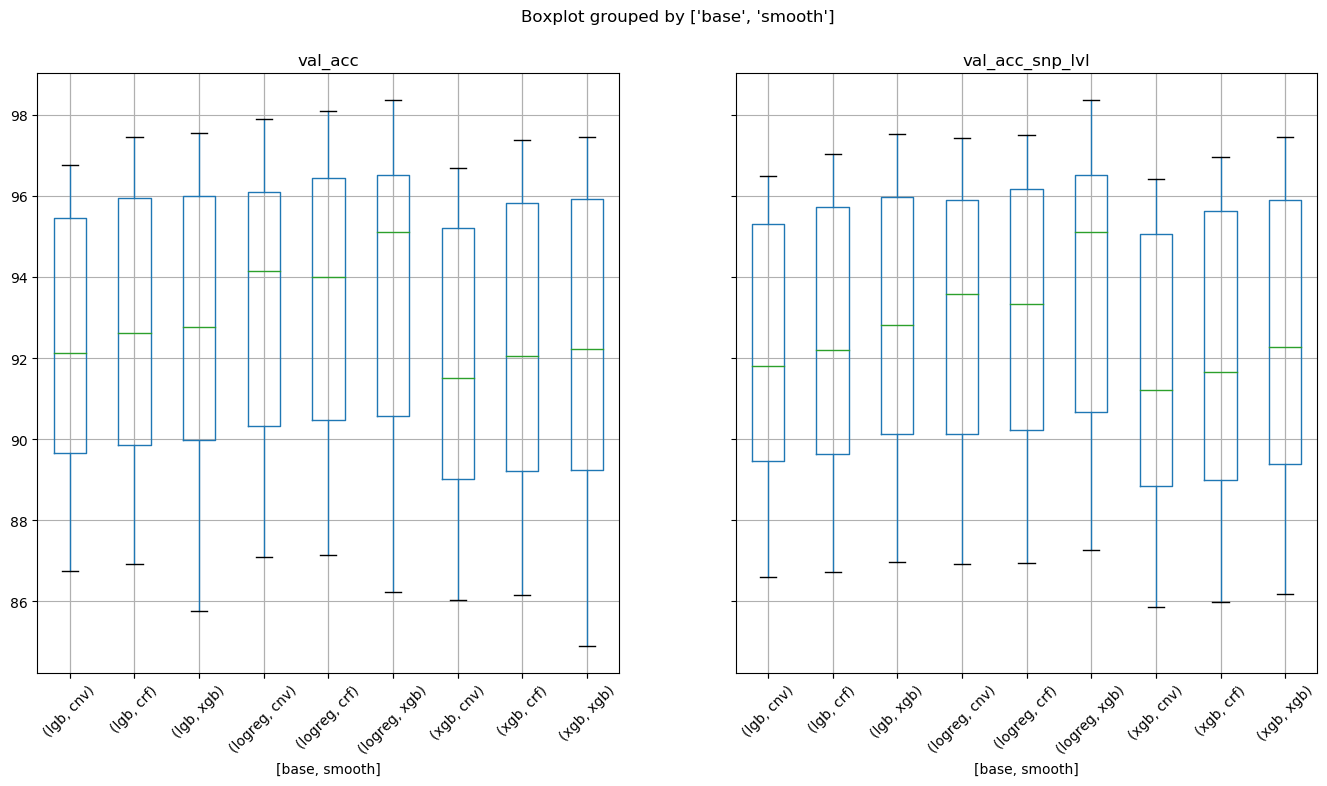

In [71]:
DF.boxplot(column=["val_acc", "val_acc_snp_lvl"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

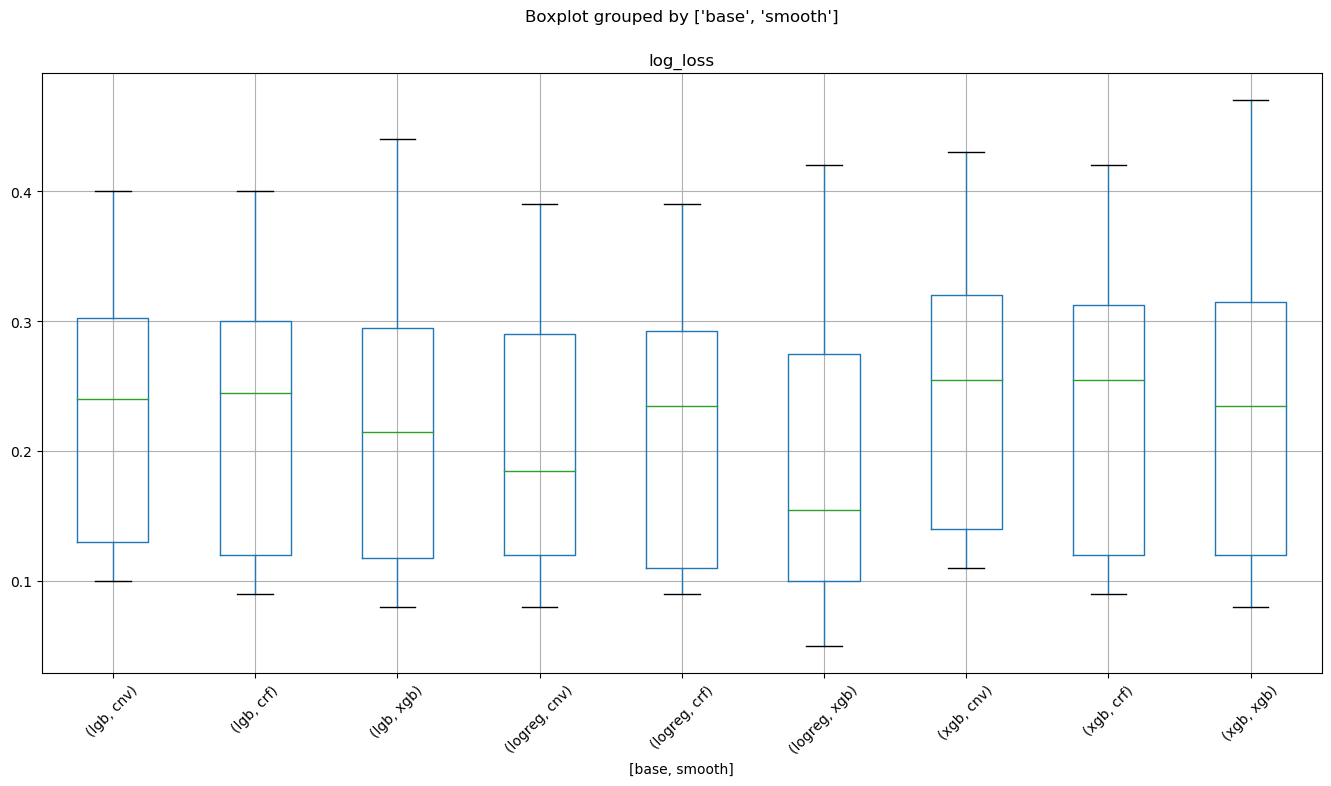

In [72]:
DF.boxplot(column=["log_loss"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

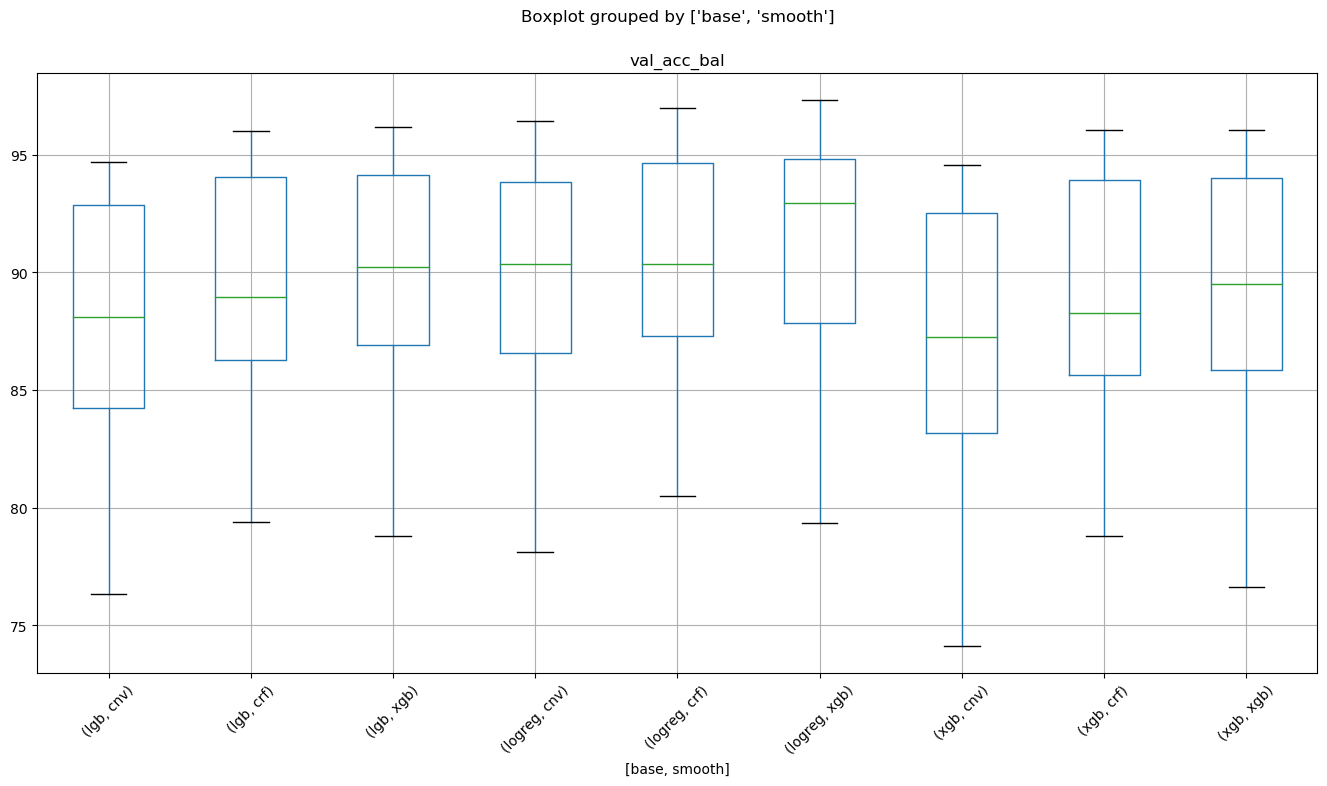

In [51]:
DF.boxplot(column=["val_acc_bal"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

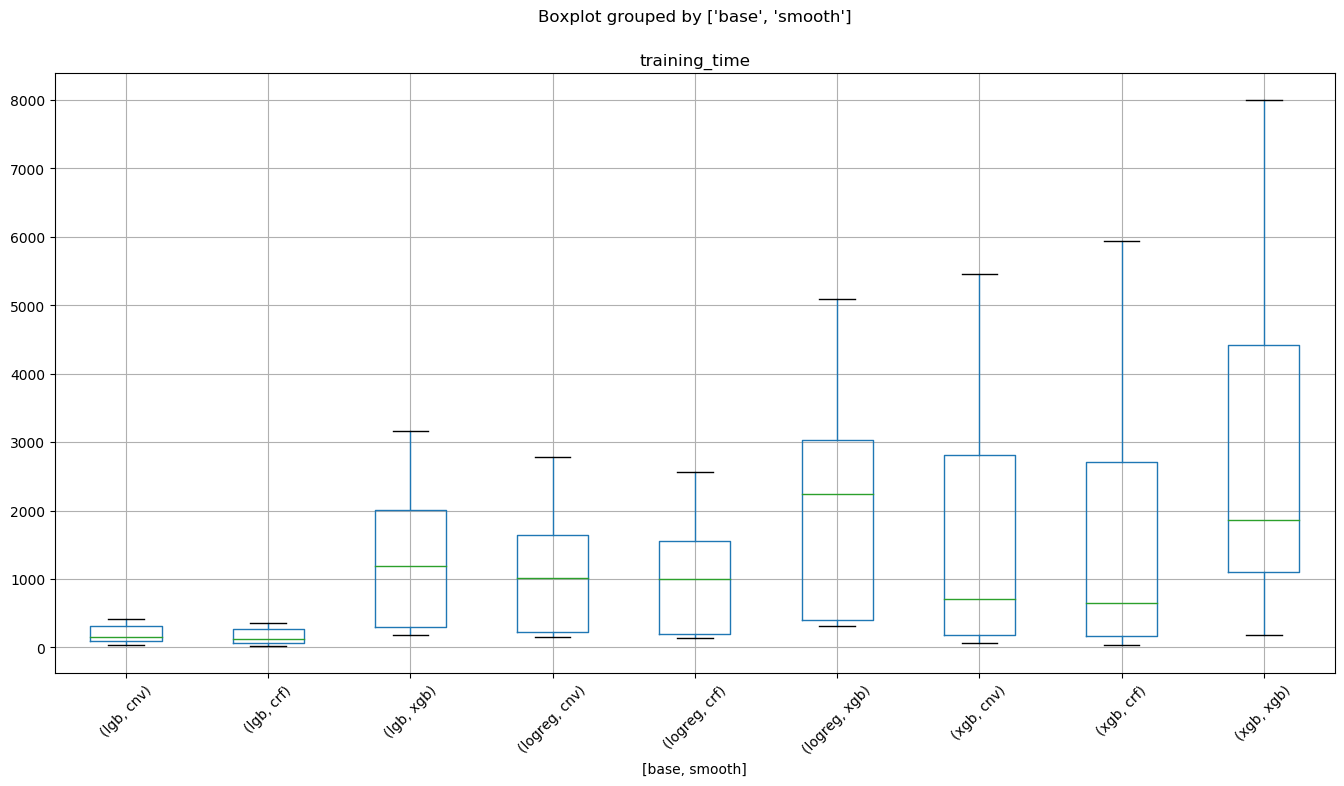

In [42]:
DF.boxplot(column=["training_time"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

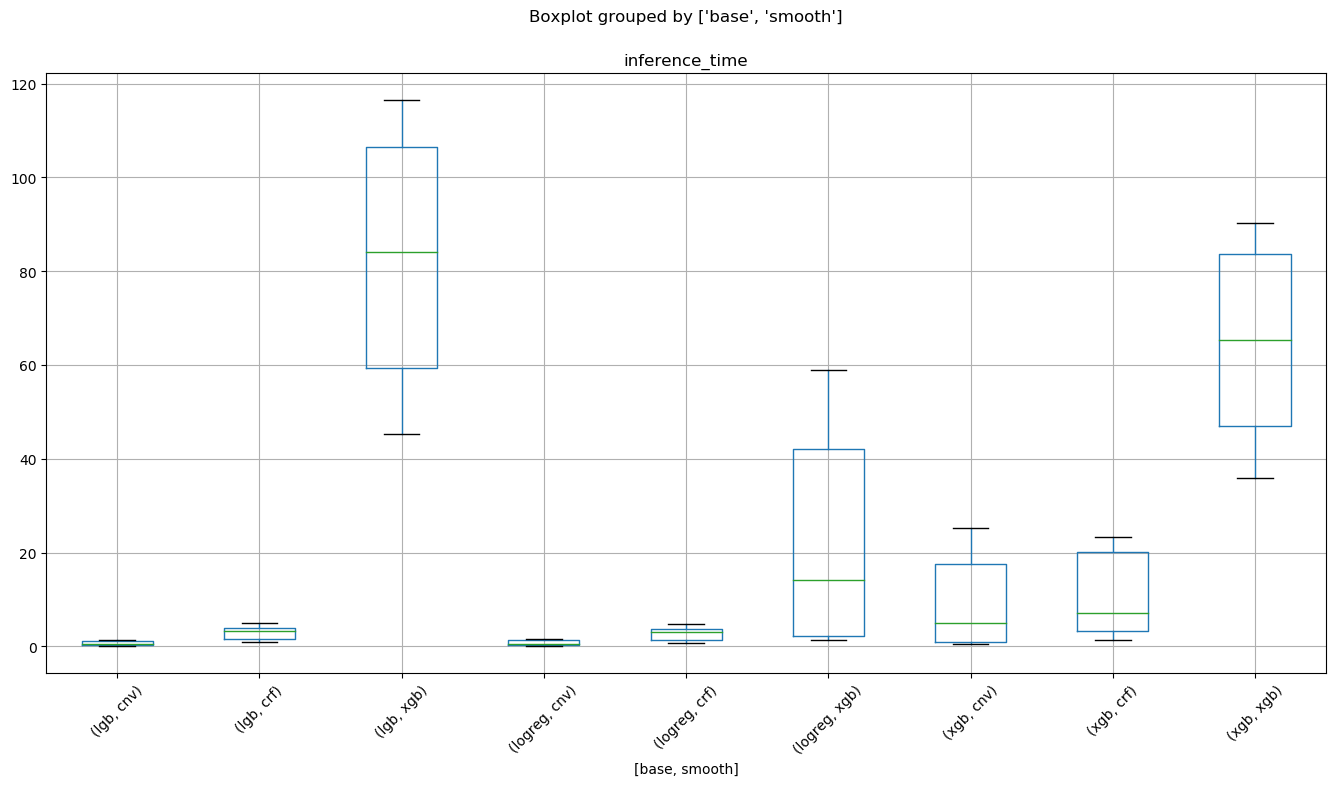

In [41]:
DF.boxplot(column=["inference_time"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

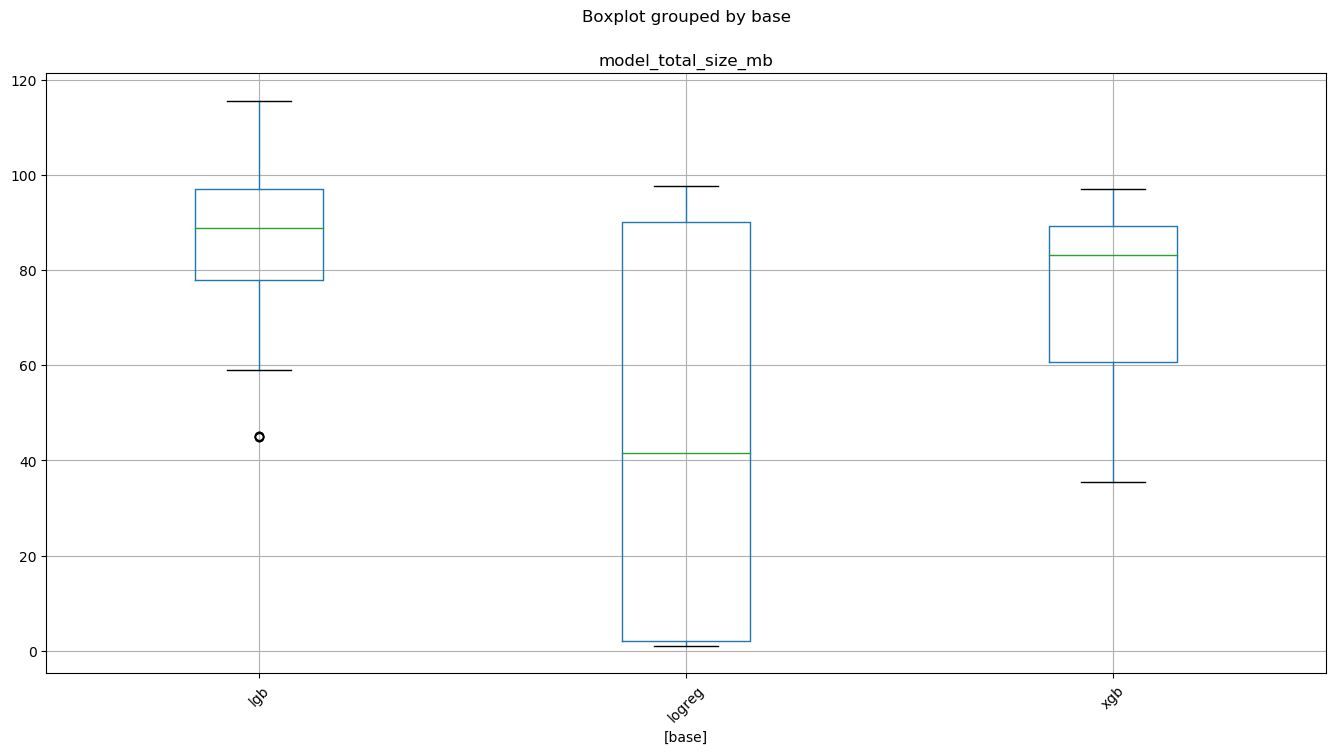

In [47]:
DF.boxplot(column=["model_total_size_mb"], by=["base"], figsize=(16,8), rot="45")
plt.show()

In [ ]:
DF.boxplot(column=["val_acc"], by=["snp", "base", "smooth"], figsize=(16,8), rot="45")
plt.show()

## Closer look

In [ ]:
DF_best_models = DF[ 
    ~(DF.base.isin(["rf", "lgb"])) &
    (DF.smooth != "cnv")
]
DF_best_models.boxplot(column=["val_acc"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

## Balance not affacting much but still a bit
we want to repeat with fixed validation set

In [ ]:
DF.boxplot(column=["val_acc"], by=["data", "bal"], figsize=(16,8), rot=45)
plt.show()

## same pattern using only best models

In [ ]:
DF_best_models.boxplot(column=["val_acc"], by=["data", "bal"], figsize=(16,8), rot=45)
plt.show()

## Accuracies similar for high generations

In [ ]:
DF_lathi = DF[ 
    (DF.base != "rf") &
    (DF.smooth != "cnv") &
    (DF.gen=="high") ]
DF_lathi.boxplot(column=["val_acc"], by=["data", "snp", "smooth"], figsize=(16,8), rot=45)
plt.show()

In [ ]:
data_path = "/home/arvindsk/xgmix_expts/benchmark_data/ukb/unbal_unbal/five/"
base = ["xgb", "logreg"]
smooth = ["xgb", "crf"]
gen_name = "high"
bm_root = data_path + "generated_data/chm{}/{}/".format(chm,gen_name)
metric_path = bm_root + "benchmark_results.pkl"
M = load_dict(metric_path)
out = plt_metric(base ,smooth, M, "gen_performance")

## Note! acc > 90% for gen 100